In [ ]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
sys.path.append('..')
print(sys.path)
from nlp_pipeline.feature_extraction import FeatureExtractor
from nlp_pipeline.preprocess_text import TextPreprocessor
from model.evaluate_model import ModelEvaluator
from model.train_baseline import BaselineTrainer
from interpretation.lime_interpreter import LimeTextInterpreter
from interpretation.shap_interpreter import ShapInterpreter
from nlp_pipeline.back_translator import BackTranslationAugmentor
from nlp_pipeline.embedding_oversample import EmbeddingOversampler

['d:\\aco\\research\\Asd-classification\\notebook', 'c:\\Users\\MufliDevs\\anaconda3\\python312.zip', 'c:\\Users\\MufliDevs\\anaconda3\\DLLs', 'c:\\Users\\MufliDevs\\anaconda3\\Lib', 'c:\\Users\\MufliDevs\\anaconda3', '', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\win32', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\MufliDevs\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor', '..', '..', '..']


Load dataset + Augmented

In [ ]:
df = df = pd.read_csv('../data/feature/merged_final.csv', encoding='latin1')
columns = ['label', 'transcription', 'total_words', 'unique_words', 'num_sentences',
                   'stopwords', 'num_adjectives', 'num_nouns', 'num_verbs', 'num_adverbs',
                   'type_token_ratio', 'avg_words_per_sentence']
df = df[columns]
augmentor = BackTranslationAugmentor()
df_augmented = augmentor.augment_dataframe(df)
print(df_augmented.head)
df_augmented.to_csv('../data/feature/1_augmented.csv', index=False)

Preprocessing text

In [2]:
df = df = pd.read_csv('../data/feature/combined_augmented_asd.csv', encoding='latin1')
text_preprocessor = TextPreprocessor()
df['clean_text'] = df['transcription'].apply(text_preprocessor.preprocess)
df[['transcription', 'clean_text']].head()

,transcription,clean_text
0,Tunjuk kaka coba,tunjuk kaka coba
1,Inii!,ini
2,Siapa namamu?,siapa nama
3,Iyaaaa?,
4,Kenalan duluu!,kenal duluu


In [ ]:
df['label'].value_counts()
df['label'].value_counts()

Ekstraksi fitur with TFIDF

In [ ]:
extractor = FeatureExtractor()
X = extractor.fit_transform_tfidf(df['clean_text'])
y = df['label'].values
print(X.shape, y.shape)

Oversampling with TFIDF

In [87]:
X_dense = extractor.fit_transform_tfidf(df['clean_text']).toarray()

ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values

y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values

oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X_dense, X_ling, y)


Ekstraksi fitur with IndoBERT

In [ ]:
extractor = FeatureExtractor()
X = extractor.encode_series_bert(df['clean_text'])
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

SVC WITH 5 FOLD

In [4]:
trainer = BaselineTrainer()

evaluator = ModelEvaluator(model_type='svm',pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.941     0.805     0.868       930
           1      0.830     0.949     0.886       930

    accuracy                          0.877      1860
   macro avg      0.885     0.877     0.877      1860
weighted avg      0.885     0.877     0.877      1860

Confusion Matrix:
 [[749 181]
 [ 47 883]]
Confusion Matrix (Fold 1):
[[749 181]
 [ 47 883]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.948     0.820     0.880       930
           1      0.842     0.955     0.895       929

    accuracy                          0.888      1859
   macro avg      0.895     0.888     0.887      1859
weighted avg      0.895     0.888     0.887      1859

Confusion Matrix:
 [[763 167]
 [ 42 887]]
Confusion Matrix (Fold 2):
[[763 167]
 [ 42 887]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.940     0.828     0.8

USE THIS IF YOU NOT USING BERT

In [ ]:
final_model = trainer.train(X_embed_bal, y_bal)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results.csv")

In [ ]:
final_model = BaselineTrainer('svm').train(X_embed_bal,y_bal)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_SVM_oversample+bert.csv",
    true_labels=labels
)

LOGISTIC REGRETION WITH 5 FOLD

In [72]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.907     0.860     0.883       930
           1      0.867     0.912     0.889       930

    accuracy                          0.886      1860
   macro avg      0.887     0.886     0.886      1860
weighted avg      0.887     0.886     0.886      1860

Confusion Matrix:
 [[800 130]
 [ 82 848]]
Confusion Matrix (Fold 1):
[[800 130]
 [ 82 848]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.914     0.839     0.875       930
           1      0.851     0.921     0.885       929

    accuracy                          0.880      1859
   macro avg      0.883     0.880     0.880      1859
weighted avg      0.883     0.880     0.880      1859

Confusion Matrix:
 [[780 150]
 [ 73 856]]
Confusion Matrix (Fold 2):
[[780 150]
 [ 73 856]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.911     0.844     0.8

In [ ]:
final_model = trainer.train(X, y)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results_LOGRES.csv")

SVM WITH 10 FOLD

In [5]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(model_type='svm', n_splits= 10, random_state=32,pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.967     0.822     0.888       465
           1      0.845     0.972     0.904       465

    accuracy                          0.897       930
   macro avg      0.906     0.897     0.896       930
weighted avg      0.906     0.897     0.896       930

Confusion Matrix:
 [[382  83]
 [ 13 452]]
Confusion Matrix (Fold 1):
[[382  83]
 [ 13 452]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.948     0.828     0.884       465
           1      0.847     0.955     0.898       465

    accuracy                          0.891       930
   macro avg      0.898     0.891     0.891       930
weighted avg      0.898     0.891     0.891       930

Confusion Matrix:
 [[385  80]
 [ 21 444]]
Confusion Matrix (Fold 2):
[[385  80]
 [ 21 444]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.945     0.854     0.8

In [ ]:
final_model = trainer.train(X, y)

lime_interpreter = LimeTextInterpreter(
    model=final_model,
    vectorizer=extractor.get_tfidf_vectorizer(),
    class_names=['NON ASD', 'ASD']
)

asd_samples = df[df['label'] == 'ASD'].sample(n=12, random_state=42)
non_asd_samples = df[df['label'] == 'NON ASD'].sample(n=12, random_state=42)
lime_samples = pd.concat([asd_samples, non_asd_samples]).reset_index(drop=True)

lime_interpreter.save_lime_explanation_to_csv(lime_samples,"../reports/lime_results_SVM10FOLD.csv")

In [ ]:
final_model = BaselineTrainer('svm').train(X,y)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_SVM_10_fold.csv",
    true_labels=labels
)

LINEAR REGRETION WITH 10 FOLD

In [88]:
trainer = BaselineTrainer()
evaluator = ModelEvaluator(n_splits= 10, random_state=32,pos_label=1)

results = evaluator.cross_validate_oversample_with_confusionmatrix(X_embed_bal,y_bal)


[Oversampled] Fold 1
              precision    recall  f1-score   support

           0      0.957     0.819     0.883       465
           1      0.842     0.963     0.899       465

    accuracy                          0.891       930
   macro avg      0.900     0.891     0.891       930
weighted avg      0.900     0.891     0.891       930

Confusion Matrix:
 [[381  84]
 [ 17 448]]
Confusion Matrix (Fold 1):
[[381  84]
 [ 17 448]]

[Oversampled] Fold 2
              precision    recall  f1-score   support

           0      0.941     0.789     0.858       465
           1      0.819     0.951     0.880       465

    accuracy                          0.870       930
   macro avg      0.880     0.870     0.869       930
weighted avg      0.880     0.870     0.869       930

Confusion Matrix:
 [[367  98]
 [ 23 442]]
Confusion Matrix (Fold 2):
[[367  98]
 [ 23 442]]

[Oversampled] Fold 3
              precision    recall  f1-score   support

           0      0.944     0.837     0.8

In [ ]:
final_model = BaselineTrainer('svm').train(X,y)
interpreter = ShapInterpreter(model=final_model)
sampled_df = df.sample(n=100, random_state=42)
texts = sampled_df['clean_text'].tolist()
labels = sampled_df['label'].tolist()

shap_values = interpreter.explain(texts)
interpreter.save_shap_explanations_to_csv(
    shap_values=shap_values,
    texts=texts,
    output_path="../reports/shap_results_Logres_10_fold.csv",
    true_labels=labels
)


In [ ]:
interpreter.visualize(shap_values= shap_values)

FUSION

In [62]:
extractor = FeatureExtractor()
X = extractor.extract_fused_features_bert(df)
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

(9296, 778) (8380,)


Fusion with tfidf

In [3]:
extractor = FeatureExtractor()
X = extractor.extract_fused_features_tfidf(df, fit=True)
y = (df['label'].str.upper().str.strip() == 'ASD').astype(int).values
ling_cols = extractor.linguistic_cols
X_ling = df[ling_cols].values
oversampler = EmbeddingOversampler()
X_embed_bal, X_ling_bal, y_bal = oversampler.oversample(X, X_ling, y)

print(X_embed_bal.shape, y.shape)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

(9296, 5010) (8380,)


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [ ]:
evaluator = ModelEvaluator(model_type='svm', n_splits= 10, random_state=32)
results = evaluator.cross_validate_with_confusionmatrix(X, y)


Testing Model

In [ ]:
trainer = BaselineTrainer(model_type='svm')
model = trainer.train(X_embed_bal, y_bal)

new_text = "Apakah kamu suddah makan?"
clean_text = text_preprocessor.preprocess(new_text)
X_new = extractor.encode_series_bert([clean_text])
predicted_label = model.predict(X_new)[0]
print(f"Predicted label: {predicted_label}")

In [ ]:
new_text = "Apakah kamu sudah makan?"
clean_text = text_preprocessor.preprocess(new_text)
X_new = extractor.encode_series_bert([clean_text])
predicted_label = model.predict(X_new)[0]
print(f"Predicted label: {predicted_label}")

In [94]:
accuracy   = [0.869, 0.872, 0.873, 0.875, 0.876]
precision  = [0.834, 0.835, 0.839, 0.839, 0.846]
recall     = [0.920, 0.927, 0.921, 0.928, 0.919]
f1_scores  = [0.875, 0.879, 0.878, 0.882, 0.881]
folds = [f"Fold {i+1}" for i in range(5)]

mean_acc = sum(accuracy)/len(accuracy)
mean_prec = sum(precision)/len(precision)
mean_rec = sum(recall)/len(recall)
mean_f1 = sum(f1_scores)/len(f1_scores)

Bar plot

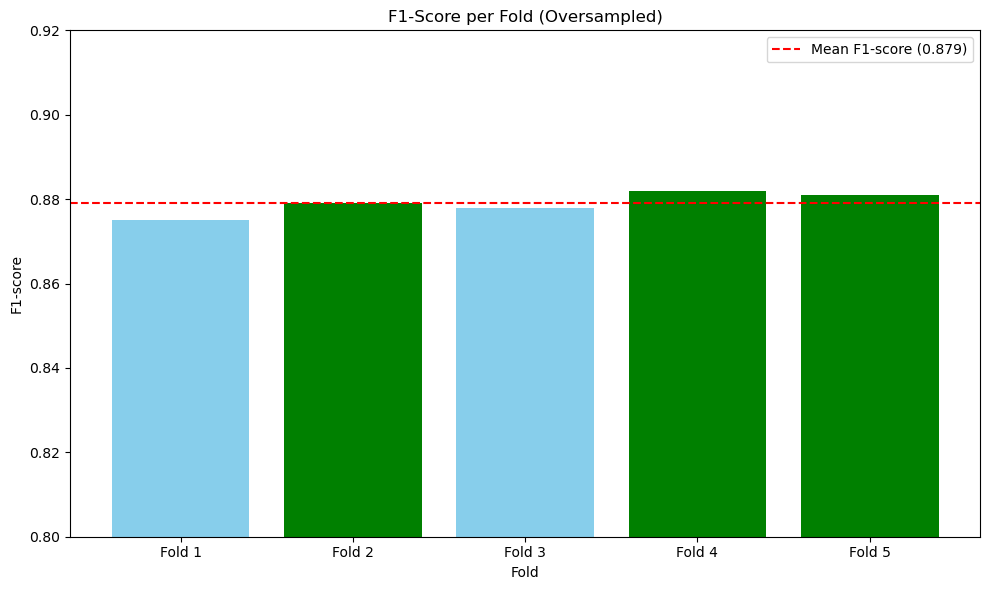

In [95]:
colors = ['green' if score > mean_f1 else 'skyblue' for score in f1_scores]
plt.figure(figsize=(10, 6))
bars = plt.bar(folds, f1_scores, color=colors)
plt.axhline(y=mean_f1, color='red', linestyle='--', label=f'Mean F1-score ({mean_f1:.3f})')
plt.title('F1-Score per Fold (Oversampled)')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.ylim(0.8, 0.92)
plt.legend()
plt.tight_layout()
plt.show()

Line plot

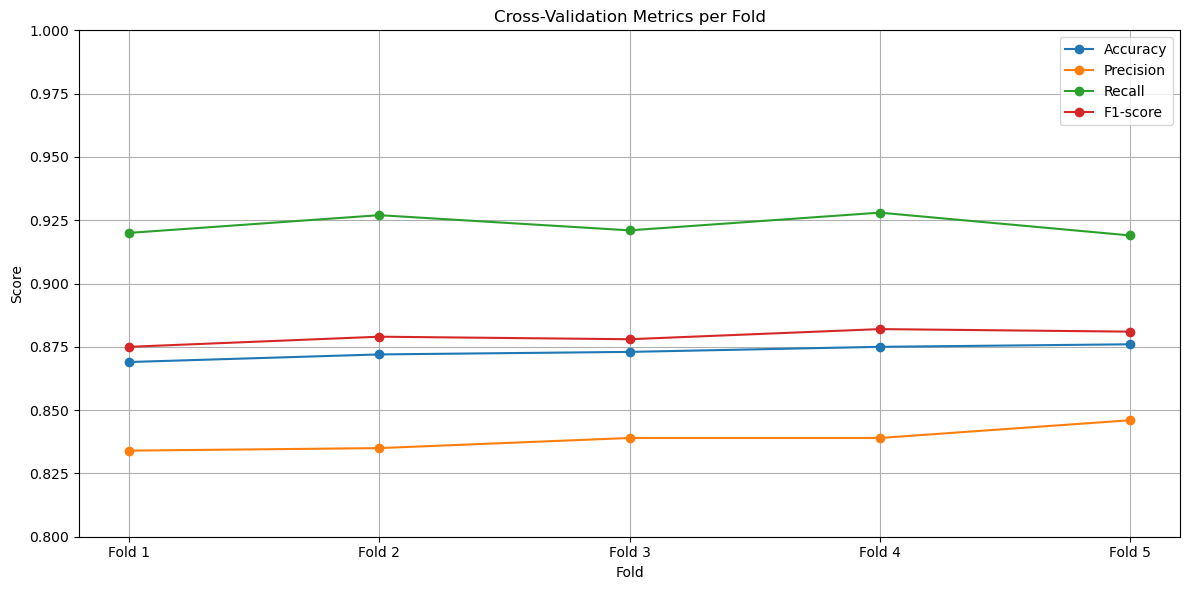

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(folds, accuracy, label='Accuracy', marker='o')
plt.plot(folds, precision, label='Precision', marker='o')
plt.plot(folds, recall, label='Recall', marker='o')
plt.plot(folds, f1_scores, label='F1-score', marker='o')
plt.title('Cross-Validation Metrics per Fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix

In [97]:
conf_matrices = [
    np.array([[760, 170], [ 74, 856]]),  # Fold 1
    np.array([[760, 170], [ 68, 861]]),  # Fold 2
    np.array([[766, 164], [ 73, 856]]),  # Fold 3
    np.array([[764, 165], [ 67, 863]]),  # Fold 4
    np.array([[773, 156], [ 75, 855]])   # Fold 5
]
agg_conf_matrix = sum(conf_matrices)
print("Aggregated Confusion Matrix:\n", agg_conf_matrix)

Aggregated Confusion Matrix:
 [[3823  825]
 [ 357 4291]]


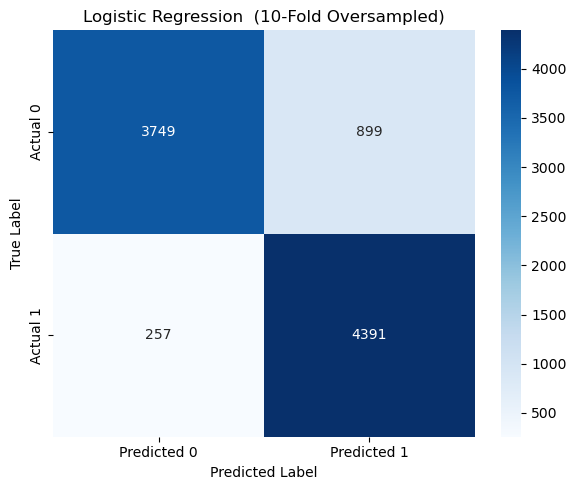

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(agg_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Support vector machine (5-Fold Oversampled)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()